## 設定參數

In [ ]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CW308_STM32F4'
CRYPTO_TARGET = 'TINYAES128C'
VERSION = 'HARDWARE'
SS_VER = 'SS_VER_1_1'

## 抓板子

In [ ]:
%run "../../Setup_Scripts/Setup_Generic.ipynb"

## 編AES-128的程式

In [ ]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER"
cd ../../../hardware/victims/firmware/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2 SS_VER=$3

## 將AES燒到板子上

In [ ]:
fw_path = '../../../hardware/victims/firmware/simpleserial-aes/simpleserial-aes-{}.hex'.format(PLATFORM)
cw.program_target(scope, prog, fw_path)

## 錄Trace、印出隨機產生的明文

In [ ]:
#Capture Traces
from tqdm.notebook import trange
import numpy as np
import time

ktp = cw.ktp.Basic()

traces = []
trace_num = 2000  # Number of traces# Number of traces

proj_name = f"traces/{PLATFORM}_{CRYPTO_TARGET}_{trace_num}_fixedkey.cwp"    # 專案檔檔名，可以知道板子 加密算法 trace數 固定金鑰
project = cw.create_project(proj_name, overwrite=True)

for i in trange(trace_num, desc='Capturing traces'):
    # ktp.next()是產生下一組隨機的key和明文
    # key是固定的、明文是隨機的
    key, text = ktp.next()  # manual creation of a key, text pair can be substituted here
    print(i, text)             # 確認下面的輸出的明文是相同的
    trace = cw.capture_trace(scope, target, text, key)                   # 抓trace
    if trace is None:
        continue
    project.traces.append(trace)                                         # 加到trace物件內
    
# 抓了300條Trace，每條Trace共有5000個點
print(f'Number of samples = {scope.adc.samples}')
project.save()

## 與板子斷開連線

In [ ]:
scope.dis()
target.dis()

## import套件

In [1]:
import chipwhisperer as cw
import numpy as np   # python中拿來做向量運算的套件，numpy是用C語言寫的，所以計算上會快很多
import matplotlib.pyplot as plt

## 對應表

In [2]:
# The AES SBox that we will use to generate our labels
AES_Sbox = np.array([
            0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
            0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
            0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
            0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
            0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
            0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
            0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
            0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
            0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
            0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
            0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
            0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
            0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
            0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
            0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
            0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
            ])
# The Hamming weight list of each byte value
hw_list = np.array([
            0, 1, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 3, 3, 4, 1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 
            1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 
            1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 
            2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 
            1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
            2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
            2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
            3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 4, 5, 5, 6, 5, 6, 6, 7, 5, 6, 6, 7, 6, 7, 7, 8
            ])
# Number of combinations for each Hamming weight
# 不同的HW共有多少種，例如 HW=0的只有一種
hw_combinations = np.array([1, 8, 28, 56, 70, 56, 28, 8, 1])

## Load Traces

In [3]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CW308_STM32F4'
CRYPTO_TARGET = 'TINYAES128C'
VERSION = 'HARDWARE'
SS_VER = 'SS_VER_1_1'

trace_num = 2000  # Number of traces

project_file_name = f"traces/{PLATFORM}_{CRYPTO_TARGET}_{trace_num}_fixedkey.cwp"   # 剛剛創的專案的路徑
print(f'Reading {project_file_name}...')
proj = cw.open_project(project_file_name)                                       # 取得專案

t = np.array(proj.waves)                                                        # 取得trace
p = np.array(proj.textins)                                                      # 取得明文
k = np.array(proj.keys)                                                         # 取得key
c = np.array(proj.textouts)                                                     # 取得輸出值
num_traces = t.shape[0]
trace_length = t.shape[1]
print(f'Number of traces = {num_traces}, trace length = {trace_length}')

Reading traces/CW308_STM32F4_TINYAES128C_2000_fixedkey.cwp...
Number of traces = 2000, trace length = 24400


## 印出明文、金鑰

In [4]:
print("Plaintext: ")
print("Size=", p.shape, sep="")
print(p)
print("")

print("Key: ")
print("Size=", k.shape, sep="")
print(k)

Plaintext: 
Size=(2000, 16)
[[240 195  62 ...  14 147 203]
 [112  58 238 ...   6 189 221]
 [246  12   3 ...  23  39  28]
 ...
 [136 146  39 ...  32 195  65]
 [234 143 146 ...   5  24 217]
 [255 131  80 ... 219  62 150]]

Key: 
Size=(2000, 16)
[[ 43 126  21 ... 207  79  60]
 [ 43 126  21 ... 207  79  60]
 [ 43 126  21 ... 207  79  60]
 ...
 [ 43 126  21 ... 207  79  60]
 [ 43 126  21 ... 207  79  60]
 [ 43 126  21 ... 207  79  60]]


## 計算相關係數(R)

In [5]:
k_guess = np.array(range(256))              # 建一個 0~255 的 numpy array，用於將明文與所有金鑰可能作xor運算
h_sum = np.zeros((16, 256))                 # 存 HW 的加總，大小為 16bytes by 00~ff 種可能的矩陣
h2_sum = np.zeros((16, 256))                # 存 HW 的平方的加總，大小為 16bytes by 00~ff 種可能的矩陣
t_sum = np.zeros((1, trace_length))         # 存 Trace 的加總
t2_sum = np.zeros((1, trace_length))        # 存 Trace 的平方的加總
h_t_sum = np.zeros((16, 256, trace_length)) # 存 HW 與 Trace 相乘後的加總
r = np.zeros((16, 256, trace_length))       # 存每一條明文和 Traces 所計算出來的相關係數，且有 16Bytes

Guess_Key = np.zeros((16), dtype=int)       # 存相關係數矩陣中有最大值的 byte 值
Point = np.zeros((16), dtype=int)           # 存
Coef = np.zeros((16))

index_per_row = np.zeros((16, 256), dtype=int)
max_coef_per_row = np.zeros((trace_num, 16, 256))   # 存每條trace中相關係數矩陣每列最大的相關係數值; 共 16bytes 故16張圖

print("計算開始")
for i in range(trace_num):
    t_sum += t[i]
    t2_sum += t[i] ** 2
    for b in range(16):                             # 共 16 bytes
        h = hw_list[AES_Sbox[p[i][b] ^ k_guess]]    # h矩陣為每一條明文的 byte 與所有金鑰可能做xor, sbox轉換, 取HW後的結果; 大小為(1, 256)
        h_sum[b] += h
        h2_sum[b] += h ** 2
        h_t_sum[b] += np.outer(h, t[i])             # 計算兩個向量的 outer product
        
        std_h = np.sqrt(h2_sum[b] - (h_sum[b] ** 2) / (i + 1)) + 1e-40 # 加一個很小的數(10的負40次方)，以避免跳出runtimewarning的警告
        std_t = np.sqrt(t2_sum - (t_sum ** 2) / (i + 1)) + 1e-40       # 加一個很小的數(10的負40次方)，以避免跳出runtimewarning的警告
        r[b] = (h_t_sum[b] - np.outer(h_sum[b], t_sum) / (i + 1)) / np.outer(std_h, std_t) # 計算相關係數值
        max_coef = np.max(np.abs(r[b]))                           # 取得每一 byte 中最大的相關係數數值
        Coef[b] = max_coef                                        # 存每一 byte 的最大相關係數值
        key_byte, point = np.where(np.abs(r[b]) == max_coef)      # 取得每一 byte 中有最大相關係數數值所在列、所在行
        Guess_Key[b] = key_byte[0]                                # 存每一 byte 存到猜測的金鑰中
        Point[b] = point[0]
        index_per_row[b] = np.argmax(np.abs(r[b]), axis=1)
        
#     print(i, test[index])    
    row_indices, col_indices = np.indices(index_per_row.shape)
    max_coef_per_row[i] = r[row_indices, col_indices, index_per_row]
 
    
    np.set_printoptions(precision=3, linewidth=np.inf)            # 設定小數點位數、不自動換行
    print("Trace{:04}:".format(i + 1))
    print("  True Key:", end="")
    print(k[0])
    print(" Guess Key:", end="")
    print(Guess_Key)
    print("Coeffcient:", end="")
    print(Coef)
    print("   Samples:", end="")
    print(Point)
    print("")
print("計算結束")

計算開始
Trace0001:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Coeffcient:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Samples:[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Trace0002:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 7  0  4  4  0  3  0  1  3  8  5  2  0 38  3 36]
Coeffcient:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
   Samples:[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]

Trace0003:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 59 136  63  58  11  32 136  37  18  60  14   3 123   3  33  79]
Coeffcient:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
   Samples:[ 2497  2497  2497  2497  2497   333 22112  2497 22112 22112   333  8357  2497 17456 22112 17456]

Trace0004:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 0  7  3  4  5  2  6  1  2 21  2  2  1  2  0 14]
Coeffcient:[1.

Trace0025:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.986 0.994 0.991 0.996 0.995 0.996 0.991 0.992 0.995 0.997 0.991 0.994 0.997 0.993 0.993 0.993]
   Samples:[1549 1757 1965 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace0026:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.986 0.994 0.991 0.996 0.995 0.996 0.987 0.992 0.994 0.996 0.99  0.994 0.997 0.991 0.993 0.993]
   Samples:[1549 1757 1965 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace0027:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.986 0.994 0.991 0.996 0.995 0.996 0.988 0.992 0.994 0.996 0.991 0.994 0.997 0.99  0.9

Trace0048:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.989 0.996 0.993 0.997 0.996 0.996 0.987 0.994 0.993 0.994 0.994 0.992 0.997 0.992 0.995 0.995]
   Samples:[1549 1757 1965 2173 1597 1805 2014 2221 1645 1853 2061 2270 1693 1901 2109 2317]

Trace0049:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.989 0.996 0.993 0.997 0.996 0.996 0.989 0.994 0.993 0.994 0.994 0.992 0.997 0.992 0.995 0.995]
   Samples:[1549 1757 1965 2173 1597 1805 2020 2221 1645 1853 2061 2270 1693 1901 2109 2317]

Trace0050:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.989 0.996 0.993 0.997 0.996 0.996 0.99  0.995 0.993 0.994 0.994 0.992 0.996 0.992 0.9

Trace0071:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.99  0.995 0.991 0.995 0.995 0.996 0.989 0.994 0.993 0.994 0.995 0.989 0.995 0.993 0.995 0.995]
   Samples:[1549 1757 1965 2173 1597 1805 2020 2221 1645 1853 2061 2270 1693 1901 2109 2317]

Trace0072:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.99  0.995 0.991 0.995 0.995 0.996 0.989 0.994 0.993 0.994 0.995 0.989 0.995 0.993 0.987 0.987]
   Samples:[1549 1757 1965 2173 1597 1805 2020 2221 1645 1853 2061 2270 1693 1901 2502 2318]

Trace0073:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.99  0.994 0.992 0.995 0.995 0.996 0.989 0.994 0.993 0.994 0.995 0.989 0.995 0.993 0.9

Trace0094:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.992 0.994 0.991 0.994 0.995 0.996 0.989 0.995 0.991 0.994 0.995 0.988 0.995 0.993 0.986 0.988]
   Samples:[1549 1757 1965 2173 1597 1805 2013 2221 1645 1853 2061 2270 1693 1901 2503 2318]

Trace0095:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.992 0.994 0.991 0.994 0.995 0.995 0.989 0.995 0.991 0.994 0.995 0.988 0.995 0.993 0.986 0.988]
   Samples:[1549 1757 1965 2173 1597 1805 2013 2221 1645 1853 2061 2270 1693 1901 2503 2318]

Trace0096:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.992 0.994 0.992 0.994 0.995 0.995 0.988 0.995 0.991 0.994 0.995 0.988 0.995 0.993 0.9

Trace0117:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.991 0.993 0.988 0.994 0.993 0.993 0.988 0.995 0.991 0.994 0.994 0.99  0.994 0.992 0.986 0.989]
   Samples:[1549 1757 2491 2173 1597 1805 2013 2221 1645 1853 2061 2270 1693 1901 2503 2318]

Trace0118:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.991 0.993 0.988 0.994 0.993 0.993 0.988 0.995 0.991 0.994 0.994 0.989 0.994 0.992 0.986 0.99 ]
   Samples:[1549 1757 2491 2173 1597 1805 2013 2221 1645 1853 2061 2270 1693 1901 2503 2318]

Trace0119:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.991 0.993 0.988 0.994 0.993 0.993 0.988 0.995 0.991 0.994 0.994 0.989 0.994 0.992 0.9

Trace0140:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.992 0.993 0.988 0.994 0.995 0.993 0.989 0.995 0.992 0.994 0.993 0.989 0.994 0.993 0.988 0.989]
   Samples:[1549 1757 2491 2173 1597 1805 2013 2221 1645 1853 2061 2270 1693 1901 2503 2318]

Trace0141:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.992 0.993 0.988 0.994 0.995 0.993 0.99  0.995 0.992 0.994 0.985 0.989 0.994 0.993 0.988 0.989]
   Samples:[1549 1757 2491 2173 1597 1805 2013 2221 1645 1853 2479 2270 1693 1901 2503 2318]

Trace0142:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.992 0.993 0.988 0.994 0.994 0.993 0.989 0.995 0.992 0.994 0.985 0.989 0.994 0.993 0.9

Trace0163:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.992 0.994 0.988 0.994 0.994 0.993 0.988 0.989 0.992 0.99  0.984 0.987 0.987 0.993 0.989 0.989]
   Samples:[1549 1757 2491 2173 1597 1805 2013 2222 1645 1854 2068 2270 1694 1901 2503 2318]

Trace0164:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.992 0.993 0.988 0.994 0.994 0.993 0.988 0.99  0.992 0.99  0.984 0.987 0.987 0.993 0.989 0.989]
   Samples:[1549 1757 2491 2173 1597 1805 2013 2222 1645 1854 2068 2270 1694 1901 2503 2318]

Trace0165:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.992 0.994 0.988 0.994 0.994 0.993 0.988 0.99  0.992 0.99  0.984 0.988 0.987 0.993 0.9

Trace0186:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.993 0.994 0.987 0.993 0.994 0.993 0.989 0.989 0.993 0.99  0.985 0.988 0.987 0.987 0.989 0.989]
   Samples:[1549 1757 2491 2173 1597 1805 2013 2222 1645 1854 2068 2270 1694 1902 2503 2318]

Trace0187:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.993 0.994 0.987 0.994 0.994 0.993 0.989 0.989 0.993 0.99  0.985 0.988 0.988 0.987 0.989 0.986]
   Samples:[1549 1757 2491 2173 1597 1805 2013 2222 1645 1854 2068 2270 1694 1902 2503 2324]

Trace0188:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.993 0.994 0.987 0.994 0.994 0.992 0.989 0.989 0.993 0.99  0.985 0.988 0.988 0.987 0.9

Trace0209:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.993 0.994 0.987 0.993 0.994 0.993 0.99  0.989 0.993 0.99  0.983 0.975 0.988 0.985 0.989 0.985]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2222 1645 1854 2478 2530 1694 1902 2503 2324]

Trace0210:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.993 0.994 0.987 0.993 0.994 0.993 0.99  0.989 0.993 0.99  0.983 0.975 0.988 0.985 0.989 0.985]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2222 1645 1854 2478 2530 1694 1902 2503 2324]

Trace0211:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.993 0.994 0.987 0.993 0.994 0.993 0.99  0.989 0.993 0.99  0.983 0.975 0.988 0.985 0.9

Trace0232:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.993 0.993 0.987 0.952 0.994 0.988 0.99  0.989 0.994 0.988 0.983 0.976 0.988 0.985 0.988 0.985]
   Samples:[1549 1757 2490 2173 1597 1806 2013 2222 1645 1854 2478 2537 1694 1902 2503 2324]

Trace0233:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.993 0.994 0.987 0.952 0.994 0.988 0.99  0.989 0.994 0.988 0.983 0.976 0.988 0.985 0.988 0.985]
   Samples:[1549 1757 2490 2173 1597 1806 2013 2222 1645 1854 2478 2537 1694 1902 2503 2324]

Trace0234:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.993 0.994 0.987 0.952 0.994 0.988 0.991 0.989 0.994 0.988 0.983 0.976 0.988 0.985 0.9

Trace0255:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.993 0.994 0.986 0.955 0.994 0.988 0.979 0.988 0.994 0.988 0.982 0.976 0.988 0.98  0.988 0.986]
   Samples:[1549 1757 2490 2173 1597 1806 2020 2222 1645 1854 2478 2537 1694 1901 2503 2324]

Trace0256:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.993 0.994 0.986 0.955 0.994 0.988 0.979 0.988 0.994 0.988 0.983 0.976 0.988 0.98  0.988 0.986]
   Samples:[1549 1757 2490 2173 1597 1806 2020 2222 1645 1854 2478 2537 1694 1901 2503 2324]

Trace0257:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.993 0.994 0.986 0.955 0.994 0.988 0.979 0.988 0.994 0.988 0.983 0.976 0.988 0.98  0.9

Trace0278:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.993 0.994 0.985 0.959 0.994 0.988 0.98  0.988 0.994 0.989 0.982 0.977 0.988 0.981 0.985 0.981]
   Samples:[1549 1757 2491 2173 1597 1806 2020 2222 1645 1854 2478 2537 1694 1901 2503 2324]

Trace0279:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.993 0.994 0.985 0.959 0.994 0.988 0.979 0.988 0.994 0.989 0.982 0.977 0.989 0.981 0.985 0.982]
   Samples:[1549 1757 2491 2173 1597 1806 2020 2222 1645 1854 2478 2537 1694 1901 2503 2324]

Trace0280:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.993 0.994 0.985 0.959 0.994 0.988 0.979 0.988 0.994 0.989 0.982 0.977 0.989 0.981 0.9

Trace0301:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.993 0.994 0.985 0.961 0.994 0.988 0.98  0.988 0.994 0.989 0.982 0.975 0.988 0.981 0.985 0.982]
   Samples:[1549 1757 2490 2173 1597 1806 2020 2222 1645 1854 2478 2537 1694 1901 2503 2324]

Trace0302:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.993 0.994 0.985 0.961 0.994 0.988 0.98  0.988 0.994 0.989 0.982 0.975 0.988 0.981 0.985 0.982]
   Samples:[1549 1757 2490 2173 1597 1806 2020 2222 1645 1854 2478 2537 1694 1901 2503 2324]

Trace0303:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.993 0.994 0.985 0.961 0.994 0.988 0.98  0.988 0.994 0.989 0.982 0.975 0.988 0.981 0.9

Trace0324:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.994 0.994 0.985 0.962 0.994 0.988 0.98  0.988 0.994 0.983 0.982 0.976 0.982 0.982 0.985 0.981]
   Samples:[1549 1757 2490 2173 1597 1806 2020 2222 1645 2434 2478 2537 1693 1901 2503 2324]

Trace0325:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.994 0.994 0.985 0.963 0.994 0.988 0.98  0.988 0.994 0.983 0.982 0.976 0.982 0.982 0.985 0.981]
   Samples:[1549 1757 2490 2173 1597 1806 2020 2222 1645 2434 2478 2537 1693 1901 2503 2324]

Trace0326:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.994 0.994 0.985 0.963 0.994 0.988 0.98  0.988 0.994 0.983 0.982 0.976 0.982 0.982 0.9

Trace0347:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.975 0.994 0.986 0.965 0.994 0.988 0.98  0.987 0.994 0.983 0.982 0.976 0.983 0.982 0.986 0.982]
   Samples:[1549 1757 2490 2173 1597 1806 2020 2222 1645 2434 2478 2537 1693 1901 2503 2324]

Trace0348:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.975 0.994 0.986 0.965 0.994 0.988 0.98  0.987 0.994 0.983 0.982 0.976 0.983 0.982 0.986 0.982]
   Samples:[1549 1757 2490 2173 1597 1806 2020 2222 1645 2434 2478 2537 1693 1901 2503 2324]

Trace0349:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.975 0.994 0.986 0.965 0.994 0.988 0.98  0.987 0.994 0.983 0.982 0.976 0.982 0.982 0.9

Trace0370:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.976 0.994 0.985 0.941 0.993 0.988 0.981 0.987 0.994 0.984 0.982 0.976 0.983 0.983 0.986 0.982]
   Samples:[1549 1757 2490 2173 1597 1806 2020 2222 1645 2434 2478 2537 1693 1901 2503 2324]

Trace0371:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.976 0.994 0.985 0.941 0.993 0.988 0.981 0.987 0.994 0.984 0.982 0.976 0.983 0.983 0.986 0.982]
   Samples:[1549 1757 2490 2173 1597 1806 2020 2222 1645 2434 2478 2537 1693 1901 2503 2324]

Trace0372:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.976 0.994 0.986 0.942 0.993 0.988 0.981 0.987 0.994 0.984 0.982 0.976 0.983 0.983 0.9

Trace0393:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.977 0.994 0.986 0.944 0.993 0.987 0.982 0.988 0.994 0.985 0.982 0.976 0.983 0.984 0.986 0.983]
   Samples:[1549 1757 2490 2173 1597 1806 2020 2222 1645 2434 2478 2537 1693 1901 2503 2324]

Trace0394:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.977 0.994 0.986 0.944 0.993 0.987 0.982 0.987 0.994 0.985 0.982 0.976 0.983 0.984 0.986 0.983]
   Samples:[1549 1757 2490 2173 1597 1806 2020 2222 1645 2434 2478 2537 1693 1901 2503 2324]

Trace0395:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.977 0.994 0.986 0.945 0.993 0.987 0.982 0.987 0.994 0.985 0.982 0.976 0.983 0.984 0.9

Trace0416:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.978 0.994 0.986 0.948 0.993 0.988 0.982 0.987 0.994 0.984 0.982 0.976 0.984 0.985 0.986 0.983]
   Samples:[1549 1757 2490 2173 1597 1806 2020 2222 1645 2434 2478 2269 1693 1901 2503 2324]

Trace0417:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.978 0.994 0.986 0.948 0.993 0.988 0.982 0.987 0.994 0.984 0.982 0.976 0.984 0.985 0.986 0.982]
   Samples:[1549 1757 2490 2173 1597 1806 2020 2222 1645 2434 2478 2269 1693 1901 2503 2324]

Trace0418:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.978 0.994 0.985 0.948 0.993 0.988 0.982 0.987 0.994 0.984 0.982 0.976 0.984 0.985 0.9

Trace0439:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.979 0.994 0.985 0.948 0.993 0.988 0.982 0.987 0.994 0.985 0.982 0.977 0.985 0.985 0.986 0.982]
   Samples:[1549 1757 2490 2173 1597 1806 2020 2222 1645 2434 2478 2269 1693 1901 2503 2324]

Trace0440:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.979 0.994 0.985 0.948 0.993 0.988 0.982 0.987 0.994 0.985 0.982 0.977 0.985 0.985 0.986 0.982]
   Samples:[1549 1757 2490 2173 1597 1806 2020 2222 1645 2434 2478 2269 1693 1901 2503 2324]

Trace0441:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.979 0.994 0.985 0.948 0.993 0.988 0.982 0.987 0.994 0.985 0.982 0.977 0.985 0.985 0.9

Trace0462:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.979 0.994 0.985 0.95  0.993 0.988 0.983 0.987 0.994 0.985 0.982 0.977 0.985 0.986 0.986 0.982]
   Samples:[1549 1757 2490 2173 1597 1805 2020 2222 1645 2434 2478 2269 1693 1901 2503 2324]

Trace0463:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.979 0.994 0.985 0.95  0.993 0.988 0.983 0.987 0.994 0.985 0.982 0.977 0.985 0.986 0.986 0.982]
   Samples:[1549 1757 2490 2173 1597 1805 2020 2222 1645 2434 2478 2269 1693 1901 2503 2324]

Trace0464:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.967 0.994 0.985 0.95  0.993 0.988 0.982 0.987 0.994 0.985 0.982 0.977 0.985 0.986 0.9

Trace0485:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.968 0.994 0.985 0.952 0.993 0.988 0.982 0.987 0.994 0.985 0.982 0.978 0.986 0.986 0.985 0.982]
   Samples:[1549 1757 2490 2173 1597 1805 2020 2222 1645 2434 2478 2269 1693 1901 2503 2324]

Trace0486:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.968 0.994 0.985 0.952 0.993 0.988 0.982 0.987 0.994 0.985 0.982 0.978 0.986 0.986 0.985 0.982]
   Samples:[1549 1757 2490 2173 1597 1805 2020 2222 1645 2434 2478 2269 1693 1901 2503 2324]

Trace0487:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.968 0.994 0.985 0.952 0.993 0.988 0.982 0.987 0.994 0.985 0.982 0.978 0.986 0.986 0.9

Trace0508:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.969 0.994 0.985 0.953 0.994 0.989 0.983 0.987 0.994 0.985 0.982 0.978 0.986 0.987 0.985 0.982]
   Samples:[1549 1757 2490 2173 1597 1805 2020 2222 1645 2434 2478 2269 1693 1901 2503 2324]

Trace0509:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.969 0.994 0.985 0.953 0.994 0.989 0.983 0.987 0.994 0.985 0.982 0.978 0.986 0.987 0.985 0.982]
   Samples:[1549 1757 2490 2173 1597 1805 2020 2222 1645 2434 2478 2269 1693 1901 2503 2324]

Trace0510:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.969 0.994 0.985 0.953 0.994 0.989 0.983 0.987 0.994 0.985 0.982 0.978 0.986 0.987 0.9

Trace0531:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.951 0.994 0.985 0.955 0.994 0.989 0.983 0.987 0.994 0.985 0.982 0.978 0.986 0.987 0.985 0.983]
   Samples:[1549 1757 2490 2173 1597 1805 2020 2222 1645 2434 2478 2269 1693 1901 2503 2324]

Trace0532:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.951 0.994 0.985 0.955 0.994 0.989 0.983 0.987 0.994 0.985 0.982 0.978 0.986 0.987 0.985 0.983]
   Samples:[1549 1757 2490 2173 1597 1805 2020 2222 1645 2434 2478 2269 1693 1901 2503 2324]

Trace0533:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.951 0.994 0.985 0.955 0.994 0.989 0.983 0.987 0.994 0.985 0.982 0.978 0.986 0.987 0.9

Trace0554:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.953 0.994 0.985 0.945 0.986 0.989 0.983 0.987 0.994 0.985 0.983 0.979 0.987 0.987 0.985 0.982]
   Samples:[1549 1757 2490 2173 1597 1805 2020 2222 1645 2434 2478 2269 1693 1901 2503 2324]

Trace0555:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.953 0.994 0.985 0.945 0.986 0.989 0.983 0.987 0.994 0.985 0.983 0.979 0.987 0.987 0.985 0.982]
   Samples:[1549 1757 2490 2173 1597 1805 2020 2222 1645 2434 2478 2269 1693 1901 2503 2324]

Trace0556:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.953 0.994 0.985 0.945 0.986 0.989 0.983 0.987 0.994 0.985 0.983 0.979 0.987 0.987 0.9

Trace0577:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.954 0.994 0.985 0.947 0.986 0.989 0.984 0.988 0.993 0.985 0.983 0.979 0.987 0.987 0.985 0.982]
   Samples:[1549 1757 2491 2173 1597 1805 2020 2222 1645 2434 2478 2269 1693 1901 2503 2324]

Trace0578:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.954 0.994 0.985 0.947 0.986 0.989 0.984 0.988 0.993 0.985 0.983 0.979 0.987 0.987 0.985 0.982]
   Samples:[1549 1757 2491 2173 1597 1805 2020 2222 1645 2434 2478 2269 1693 1901 2503 2324]

Trace0579:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.954 0.994 0.985 0.947 0.986 0.989 0.984 0.988 0.993 0.985 0.983 0.979 0.987 0.987 0.9

Trace0600:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.955 0.994 0.985 0.949 0.986 0.989 0.984 0.988 0.994 0.985 0.982 0.98  0.987 0.987 0.985 0.982]
   Samples:[1549 1757 2491 2173 1597 1805 2020 2222 1645 2434 2478 2269 1693 1901 2503 2324]

Trace0601:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.955 0.994 0.985 0.949 0.986 0.989 0.984 0.988 0.994 0.985 0.982 0.98  0.987 0.987 0.985 0.982]
   Samples:[1549 1757 2490 2173 1597 1805 2020 2222 1645 2434 2478 2269 1693 1901 2503 2324]

Trace0602:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.955 0.994 0.985 0.949 0.986 0.989 0.984 0.988 0.994 0.985 0.982 0.98  0.987 0.987 0.9

Trace0623:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.957 0.994 0.984 0.95  0.987 0.989 0.984 0.988 0.994 0.984 0.982 0.98  0.987 0.988 0.984 0.983]
   Samples:[1549 1757 2490 2173 1597 1805 2020 2222 1645 2434 2478 2269 1693 1901 2503 2324]

Trace0624:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.957 0.994 0.984 0.95  0.987 0.989 0.984 0.988 0.994 0.984 0.982 0.98  0.987 0.988 0.984 0.983]
   Samples:[1549 1757 2490 2173 1597 1805 2020 2222 1645 2434 2478 2269 1693 1901 2503 2324]

Trace0625:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.957 0.994 0.985 0.95  0.987 0.989 0.984 0.988 0.994 0.984 0.982 0.98  0.987 0.988 0.9

Trace0646:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.958 0.994 0.984 0.952 0.987 0.989 0.983 0.988 0.994 0.984 0.982 0.981 0.987 0.988 0.975 0.983]
   Samples:[1549 1757 2490 2173 1597 1805 2020 2222 1645 2434 2478 2269 1693 1901 2494 2324]

Trace0647:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.958 0.994 0.984 0.952 0.987 0.99  0.983 0.988 0.994 0.984 0.982 0.981 0.987 0.988 0.975 0.983]
   Samples:[1549 1757 2490 2173 1597 1805 2020 2222 1645 2434 2478 2269 1693 1901 2494 2324]

Trace0648:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.959 0.994 0.984 0.952 0.987 0.99  0.983 0.988 0.994 0.984 0.982 0.981 0.987 0.988 0.9

Trace0669:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.96  0.994 0.984 0.952 0.987 0.99  0.965 0.988 0.994 0.984 0.982 0.981 0.988 0.988 0.967 0.982]
   Samples:[1549 1757 2490 2173 1597 1805 2014 2222 1645 2434 2478 2269 1693 1901 2109 2324]

Trace0670:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.96  0.994 0.984 0.953 0.987 0.99  0.965 0.988 0.994 0.984 0.982 0.982 0.988 0.988 0.967 0.982]
   Samples:[1549 1757 2490 2173 1597 1805 2014 2222 1645 2434 2478 2269 1693 1901 2109 2324]

Trace0671:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.96  0.994 0.984 0.953 0.987 0.99  0.965 0.988 0.994 0.984 0.982 0.982 0.988 0.988 0.9

Trace0692:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.961 0.994 0.984 0.953 0.987 0.99  0.965 0.988 0.994 0.984 0.982 0.982 0.988 0.988 0.968 0.982]
   Samples:[1549 1757 2490 2173 1597 1805 2014 2222 1645 2434 2478 2269 1693 1901 2109 2324]

Trace0693:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.961 0.994 0.984 0.953 0.987 0.99  0.965 0.988 0.994 0.983 0.982 0.982 0.988 0.988 0.968 0.982]
   Samples:[1549 1757 2491 2173 1597 1805 2014 2222 1645 2434 2478 2269 1693 1901 2109 2324]

Trace0694:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.961 0.994 0.984 0.953 0.987 0.99  0.965 0.988 0.994 0.983 0.982 0.982 0.988 0.988 0.9

Trace0715:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.961 0.994 0.984 0.95  0.988 0.99  0.965 0.988 0.994 0.983 0.982 0.982 0.988 0.989 0.968 0.982]
   Samples:[1549 1757 2491 2174 1597 1805 2014 2222 1645 2434 2478 2269 1693 1901 2109 2324]

Trace0716:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.961 0.994 0.984 0.95  0.988 0.99  0.965 0.988 0.994 0.983 0.982 0.982 0.988 0.989 0.968 0.982]
   Samples:[1549 1757 2491 2174 1597 1805 2014 2222 1645 2434 2478 2269 1693 1901 2109 2324]

Trace0717:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.961 0.994 0.984 0.95  0.988 0.99  0.965 0.988 0.994 0.983 0.982 0.982 0.988 0.989 0.9

Trace0738:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.962 0.994 0.984 0.951 0.988 0.99  0.966 0.988 0.994 0.983 0.982 0.982 0.988 0.983 0.969 0.966]
   Samples:[1549 1757 2491 2174 1597 1805 2014 2222 1645 2434 2478 2269 1693 1902 2109 2317]

Trace0739:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.962 0.994 0.984 0.951 0.988 0.99  0.966 0.988 0.994 0.983 0.982 0.982 0.989 0.983 0.969 0.966]
   Samples:[1549 1757 2491 2174 1597 1805 2014 2222 1645 2434 2478 2269 1693 1902 2109 2317]

Trace0740:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.962 0.994 0.984 0.951 0.988 0.99  0.966 0.988 0.994 0.983 0.982 0.982 0.988 0.983 0.9

Trace0761:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.962 0.994 0.984 0.953 0.988 0.99  0.966 0.988 0.994 0.983 0.982 0.983 0.989 0.983 0.97  0.966]
   Samples:[1549 1757 2491 2174 1597 1805 2014 2222 1645 2434 2478 2269 1693 1902 2109 2317]

Trace0762:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.962 0.994 0.984 0.953 0.988 0.99  0.966 0.988 0.994 0.983 0.982 0.983 0.989 0.983 0.97  0.966]
   Samples:[1549 1757 2491 2174 1597 1805 2014 2222 1645 2434 2478 2269 1693 1902 2109 2317]

Trace0763:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.962 0.994 0.984 0.953 0.988 0.99  0.966 0.988 0.994 0.983 0.982 0.983 0.989 0.983 0.9

Trace0784:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.963 0.994 0.984 0.953 0.988 0.99  0.967 0.988 0.994 0.983 0.982 0.983 0.989 0.984 0.97  0.967]
   Samples:[1549 1757 2491 2174 1597 1805 2014 2222 1645 2434 2478 2269 1693 1902 2109 2317]

Trace0785:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.963 0.994 0.984 0.953 0.988 0.99  0.967 0.988 0.994 0.983 0.982 0.983 0.989 0.984 0.97  0.967]
   Samples:[1549 1757 2491 2174 1597 1805 2014 2222 1645 2434 2478 2269 1693 1902 2109 2317]

Trace0786:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.963 0.994 0.984 0.954 0.988 0.99  0.968 0.988 0.994 0.983 0.982 0.983 0.989 0.984 0.9

Trace0807:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.963 0.994 0.985 0.955 0.988 0.99  0.968 0.983 0.994 0.983 0.983 0.983 0.989 0.983 0.971 0.968]
   Samples:[1549 1757 2491 2174 1597 1805 2014 2222 1645 2434 2478 2269 1693 1902 2109 2317]

Trace0808:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.963 0.994 0.984 0.955 0.988 0.99  0.968 0.983 0.994 0.983 0.983 0.983 0.989 0.983 0.971 0.968]
   Samples:[1549 1757 2491 2174 1597 1805 2014 2222 1645 2434 2478 2269 1693 1902 2109 2317]

Trace0809:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.963 0.994 0.984 0.955 0.988 0.99  0.968 0.983 0.994 0.983 0.982 0.983 0.989 0.983 0.9

Trace0830:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.964 0.994 0.984 0.956 0.988 0.99  0.969 0.983 0.994 0.983 0.982 0.984 0.989 0.984 0.972 0.968]
   Samples:[1549 1757 2491 2174 1597 1805 2014 2222 1645 2434 2478 2269 1693 1902 2109 2317]

Trace0831:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.964 0.994 0.984 0.956 0.988 0.99  0.969 0.983 0.994 0.983 0.983 0.984 0.989 0.983 0.972 0.969]
   Samples:[1549 1757 2491 2174 1597 1805 2014 2222 1645 2434 2478 2269 1693 1902 2109 2317]

Trace0832:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.964 0.994 0.984 0.956 0.988 0.99  0.969 0.983 0.994 0.983 0.983 0.984 0.989 0.983 0.9

Trace0853:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.965 0.994 0.984 0.957 0.988 0.991 0.969 0.984 0.994 0.983 0.982 0.984 0.989 0.984 0.972 0.97 ]
   Samples:[1549 1757 2491 2174 1597 1805 2014 2222 1645 2434 2478 2269 1693 1902 2109 2317]

Trace0854:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.965 0.994 0.984 0.957 0.988 0.991 0.969 0.984 0.994 0.983 0.982 0.984 0.989 0.984 0.972 0.97 ]
   Samples:[1549 1757 2491 2174 1597 1805 2014 2222 1645 2434 2478 2269 1693 1902 2109 2317]

Trace0855:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.965 0.994 0.984 0.957 0.988 0.991 0.969 0.984 0.994 0.983 0.982 0.984 0.989 0.984 0.9

Trace0876:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.952 0.994 0.984 0.958 0.989 0.991 0.97  0.984 0.994 0.983 0.982 0.984 0.989 0.984 0.973 0.97 ]
   Samples:[1549 1757 2491 2174 1597 1805 2014 2222 1645 2434 2478 2269 1693 1902 2109 2317]

Trace0877:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.952 0.994 0.984 0.958 0.989 0.991 0.97  0.984 0.994 0.983 0.982 0.984 0.989 0.984 0.973 0.97 ]
   Samples:[1549 1757 2491 2174 1597 1805 2014 2222 1645 2434 2478 2269 1693 1902 2109 2317]

Trace0878:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.952 0.994 0.984 0.958 0.989 0.991 0.97  0.984 0.994 0.983 0.982 0.984 0.989 0.984 0.9

Trace0899:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.953 0.987 0.984 0.953 0.989 0.991 0.97  0.984 0.994 0.983 0.982 0.984 0.99  0.984 0.973 0.965]
   Samples:[1549 1758 2491 2173 1597 1805 2014 2222 1645 2434 2478 2269 1693 1902 2109 2317]

Trace0900:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.953 0.987 0.984 0.953 0.989 0.991 0.97  0.984 0.994 0.983 0.982 0.984 0.99  0.984 0.973 0.965]
   Samples:[1549 1758 2491 2173 1597 1805 2014 2222 1645 2434 2478 2269 1693 1902 2109 2317]

Trace0901:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.953 0.987 0.984 0.953 0.989 0.991 0.97  0.984 0.994 0.983 0.982 0.984 0.99  0.984 0.9

Trace0922:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.946 0.987 0.985 0.946 0.989 0.991 0.97  0.984 0.994 0.983 0.983 0.985 0.99  0.983 0.974 0.966]
   Samples:[1549 1758 2491 2173 1597 1805 2014 2222 1645 2434 2478 2269 1693 1902 2109 2317]

Trace0923:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.946 0.987 0.985 0.946 0.989 0.991 0.97  0.984 0.994 0.983 0.983 0.985 0.99  0.983 0.974 0.966]
   Samples:[1549 1758 2491 2173 1597 1805 2014 2222 1645 2434 2478 2269 1693 1902 2109 2317]

Trace0924:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.946 0.987 0.985 0.946 0.989 0.991 0.97  0.984 0.994 0.983 0.983 0.985 0.99  0.983 0.9

Trace0945:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.947 0.987 0.985 0.947 0.989 0.991 0.971 0.984 0.994 0.983 0.982 0.985 0.99  0.984 0.974 0.967]
   Samples:[1549 1758 2491 2173 1597 1805 2014 2222 1645 2434 2478 2269 1693 1902 2109 2317]

Trace0946:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.947 0.987 0.985 0.947 0.989 0.991 0.97  0.984 0.994 0.983 0.982 0.985 0.99  0.984 0.974 0.967]
   Samples:[1549 1758 2491 2173 1597 1805 2014 2222 1645 2434 2478 2269 1693 1902 2109 2317]

Trace0947:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.947 0.987 0.985 0.947 0.989 0.991 0.97  0.984 0.994 0.983 0.982 0.985 0.99  0.984 0.9

Trace0968:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.948 0.987 0.985 0.946 0.989 0.989 0.971 0.984 0.994 0.983 0.983 0.985 0.99  0.983 0.975 0.967]
   Samples:[1549 1758 2491 2173 1597 1805 2014 2222 1645 2434 2478 2269 1693 1902 2109 2317]

Trace0969:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.948 0.987 0.985 0.946 0.989 0.989 0.971 0.984 0.994 0.983 0.982 0.985 0.99  0.983 0.975 0.967]
   Samples:[1549 1758 2491 2173 1597 1805 2014 2222 1645 2434 2478 2269 1693 1902 2109 2317]

Trace0970:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.948 0.987 0.985 0.946 0.989 0.989 0.971 0.984 0.994 0.983 0.982 0.985 0.99  0.983 0.9

Trace0991:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.948 0.987 0.985 0.947 0.989 0.989 0.971 0.97  0.994 0.983 0.978 0.985 0.99  0.983 0.975 0.966]
   Samples:[1549 1758 2491 2173 1597 1805 2014 2222 1645 2434 2068 2269 1693 1902 2109 2317]

Trace0992:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.948 0.987 0.985 0.947 0.989 0.989 0.971 0.97  0.994 0.983 0.978 0.985 0.99  0.983 0.975 0.966]
   Samples:[1549 1758 2491 2173 1597 1805 2014 2222 1645 2434 2068 2269 1693 1902 2109 2317]

Trace0993:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.948 0.987 0.985 0.947 0.989 0.989 0.971 0.97  0.994 0.983 0.978 0.985 0.99  0.983 0.9

Trace1014:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.943 0.987 0.985 0.948 0.99  0.989 0.971 0.971 0.994 0.977 0.978 0.985 0.99  0.979 0.976 0.967]
   Samples:[1549 1758 2491 2173 1597 1805 2014 2222 1645 1853 2068 2269 1693 1901 2109 2317]

Trace1015:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.943 0.987 0.985 0.948 0.989 0.989 0.971 0.971 0.994 0.977 0.978 0.985 0.99  0.979 0.976 0.967]
   Samples:[1549 1758 2491 2173 1597 1805 2014 2222 1645 1853 2068 2269 1693 1901 2109 2317]

Trace1016:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.943 0.987 0.985 0.948 0.989 0.989 0.971 0.971 0.994 0.977 0.978 0.985 0.99  0.979 0.9

Trace1037:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.943 0.988 0.985 0.947 0.99  0.989 0.971 0.968 0.994 0.977 0.978 0.985 0.99  0.979 0.976 0.968]
   Samples:[1549 1758 2491 2173 1597 1805 2014 2221 1645 1853 2068 2269 1693 1901 2109 2317]

Trace1038:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.943 0.988 0.985 0.947 0.99  0.989 0.971 0.968 0.994 0.977 0.978 0.985 0.99  0.979 0.976 0.968]
   Samples:[1549 1758 2491 2173 1597 1805 2014 2221 1645 1853 2068 2269 1693 1901 2109 2317]

Trace1039:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.944 0.988 0.985 0.947 0.99  0.989 0.971 0.968 0.994 0.977 0.979 0.985 0.99  0.979 0.9

Trace1060:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.944 0.987 0.985 0.948 0.99  0.989 0.972 0.969 0.994 0.978 0.978 0.985 0.99  0.979 0.976 0.968]
   Samples:[1549 1758 2491 2173 1597 1805 2014 2221 1645 1853 2068 2269 1693 1901 2109 2317]

Trace1061:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.944 0.987 0.985 0.948 0.99  0.989 0.972 0.969 0.994 0.978 0.978 0.985 0.99  0.979 0.976 0.968]
   Samples:[1549 1758 2491 2173 1597 1805 2014 2221 1645 1853 2068 2269 1693 1901 2109 2317]

Trace1062:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.944 0.987 0.985 0.948 0.99  0.989 0.972 0.969 0.994 0.978 0.978 0.985 0.99  0.979 0.9

Trace1083:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.945 0.987 0.985 0.94  0.99  0.989 0.972 0.969 0.994 0.978 0.979 0.986 0.99  0.98  0.977 0.969]
   Samples:[1549 1758 2491 2173 1597 1805 2014 2221 1645 1853 2068 2269 1693 1901 2109 2317]

Trace1084:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.945 0.987 0.985 0.94  0.99  0.989 0.972 0.969 0.994 0.978 0.979 0.981 0.99  0.98  0.977 0.969]
   Samples:[1549 1758 2491 2173 1597 1805 2014 2221 1645 1853 2068 2269 1693 1901 2109 2317]

Trace1085:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.945 0.987 0.985 0.94  0.99  0.99  0.972 0.97  0.994 0.978 0.979 0.981 0.99  0.98  0.9

Trace1106:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.944 0.987 0.985 0.941 0.99  0.99  0.972 0.97  0.994 0.979 0.979 0.981 0.99  0.98  0.977 0.969]
   Samples:[1549 1758 2491 2173 1597 1805 2014 2221 1645 1853 2068 2269 1693 1901 2109 2317]

Trace1107:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.944 0.987 0.985 0.941 0.99  0.99  0.972 0.97  0.994 0.979 0.979 0.981 0.99  0.98  0.977 0.969]
   Samples:[1549 1758 2491 2173 1597 1805 2014 2221 1645 1853 2068 2269 1693 1901 2109 2317]

Trace1108:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.944 0.987 0.985 0.941 0.99  0.99  0.972 0.97  0.994 0.979 0.979 0.981 0.99  0.98  0.9

Trace1129:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.945 0.987 0.985 0.942 0.99  0.99  0.97  0.97  0.994 0.979 0.979 0.982 0.99  0.98  0.977 0.97 ]
   Samples:[1549 1758 2491 2173 1597 1805 2020 2221 1645 1853 2068 2269 1693 1901 2109 2317]

Trace1130:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.945 0.987 0.985 0.942 0.99  0.99  0.97  0.97  0.994 0.979 0.979 0.982 0.99  0.98  0.977 0.97 ]
   Samples:[1549 1758 2491 2173 1597 1805 2020 2221 1645 1853 2068 2269 1693 1901 2109 2317]

Trace1131:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.945 0.987 0.985 0.942 0.99  0.99  0.97  0.97  0.994 0.979 0.979 0.982 0.99  0.98  0.9

Trace1152:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.941 0.987 0.985 0.943 0.99  0.99  0.971 0.971 0.994 0.979 0.979 0.974 0.99  0.981 0.977 0.97 ]
   Samples:[1549 1758 2491 2173 1597 1805 2020 2221 1645 1853 2068 2269 1693 1901 2109 2317]

Trace1153:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.941 0.987 0.985 0.943 0.99  0.99  0.971 0.971 0.994 0.979 0.979 0.974 0.99  0.981 0.977 0.97 ]
   Samples:[1549 1758 2491 2173 1597 1805 2020 2221 1645 1853 2068 2269 1693 1901 2109 2317]

Trace1154:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.941 0.987 0.985 0.943 0.99  0.99  0.971 0.971 0.994 0.979 0.979 0.974 0.99  0.981 0.9

Trace1175:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.941 0.987 0.985 0.943 0.99  0.99  0.971 0.971 0.994 0.979 0.979 0.974 0.99  0.981 0.978 0.971]
   Samples:[1549 1758 2491 2173 1597 1805 2020 2221 1645 1853 2068 2269 1693 1901 2109 2317]

Trace1176:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.941 0.987 0.985 0.944 0.99  0.99  0.971 0.971 0.994 0.979 0.979 0.974 0.99  0.981 0.978 0.971]
   Samples:[1549 1758 2491 2173 1597 1805 2020 2221 1645 1853 2068 2269 1693 1901 2109 2317]

Trace1177:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.941 0.987 0.985 0.944 0.99  0.99  0.971 0.971 0.994 0.979 0.979 0.974 0.99  0.981 0.9

Trace1198:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.942 0.987 0.985 0.944 0.99  0.99  0.971 0.971 0.994 0.98  0.979 0.975 0.99  0.981 0.978 0.971]
   Samples:[1549 1758 2491 2173 1597 1805 2020 2221 1645 1853 2068 2269 1693 1901 2109 2317]

Trace1199:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.942 0.987 0.985 0.944 0.99  0.99  0.971 0.971 0.994 0.98  0.979 0.975 0.99  0.981 0.978 0.971]
   Samples:[1549 1758 2491 2173 1597 1805 2020 2221 1645 1853 2068 2269 1693 1901 2109 2317]

Trace1200:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.942 0.987 0.985 0.944 0.99  0.99  0.971 0.971 0.994 0.98  0.979 0.975 0.99  0.981 0.9

Trace1221:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.94  0.987 0.985 0.945 0.99  0.99  0.971 0.972 0.994 0.98  0.971 0.975 0.99  0.981 0.977 0.972]
   Samples:[1549 1758 2491 2173 1597 1805 2020 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1222:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.94  0.987 0.985 0.945 0.99  0.99  0.971 0.972 0.994 0.98  0.971 0.975 0.99  0.981 0.977 0.972]
   Samples:[1549 1758 2491 2173 1597 1805 2020 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1223:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.94  0.987 0.985 0.945 0.99  0.99  0.971 0.972 0.994 0.98  0.971 0.975 0.99  0.981 0.9

Trace1244:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.941 0.987 0.984 0.946 0.99  0.99  0.972 0.972 0.994 0.98  0.971 0.975 0.99  0.982 0.977 0.972]
   Samples:[1549 1758 2490 2173 1597 1805 2020 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1245:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.941 0.987 0.984 0.946 0.99  0.99  0.972 0.972 0.994 0.98  0.971 0.975 0.99  0.982 0.977 0.972]
   Samples:[1549 1758 2490 2173 1597 1805 2020 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1246:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.941 0.987 0.984 0.946 0.99  0.99  0.972 0.972 0.994 0.98  0.971 0.975 0.99  0.982 0.9

Trace1267:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.942 0.987 0.984 0.947 0.985 0.99  0.972 0.972 0.994 0.98  0.971 0.975 0.991 0.982 0.978 0.972]
   Samples:[1549 1758 2490 2173 1597 1805 2020 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1268:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.942 0.987 0.984 0.947 0.985 0.99  0.972 0.972 0.994 0.98  0.971 0.975 0.991 0.982 0.978 0.972]
   Samples:[1549 1758 2490 2173 1597 1805 2020 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1269:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.942 0.987 0.984 0.947 0.985 0.99  0.972 0.972 0.994 0.981 0.971 0.975 0.991 0.982 0.9

Trace1290:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.937 0.987 0.984 0.947 0.985 0.987 0.972 0.973 0.994 0.981 0.972 0.976 0.991 0.982 0.978 0.973]
   Samples:[1549 1758 2490 2173 1597 1805 2020 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1291:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.937 0.987 0.984 0.947 0.985 0.987 0.972 0.973 0.994 0.981 0.972 0.976 0.991 0.982 0.978 0.973]
   Samples:[1549 1758 2490 2173 1597 1805 2020 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1292:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.937 0.987 0.984 0.947 0.985 0.987 0.972 0.973 0.994 0.981 0.972 0.976 0.991 0.982 0.9

Trace1313:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.936 0.98  0.985 0.948 0.985 0.987 0.968 0.973 0.994 0.981 0.972 0.976 0.991 0.981 0.978 0.973]
   Samples:[1549 1757 2490 2173 1597 1805 2020 2221 1645 1853 2061 2269 1693 1902 2109 2317]

Trace1314:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.936 0.98  0.985 0.948 0.985 0.987 0.968 0.973 0.994 0.981 0.972 0.976 0.991 0.981 0.978 0.973]
   Samples:[1549 1757 2490 2173 1597 1805 2020 2221 1645 1853 2061 2269 1693 1902 2109 2317]

Trace1315:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.936 0.98  0.984 0.948 0.985 0.987 0.968 0.973 0.994 0.981 0.972 0.976 0.991 0.981 0.9

Trace1336:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.937 0.98  0.985 0.949 0.985 0.987 0.968 0.973 0.994 0.981 0.972 0.976 0.991 0.982 0.978 0.973]
   Samples:[1549 1757 2490 2173 1597 1805 2020 2221 1645 1853 2061 2269 1693 1902 2109 2317]

Trace1337:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.937 0.98  0.985 0.949 0.985 0.987 0.968 0.973 0.994 0.981 0.972 0.976 0.991 0.981 0.978 0.973]
   Samples:[1549 1757 2490 2173 1597 1805 2020 2221 1645 1853 2061 2269 1693 1902 2109 2317]

Trace1338:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.937 0.98  0.985 0.949 0.985 0.987 0.968 0.973 0.994 0.981 0.972 0.976 0.991 0.981 0.9

Trace1359:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.938 0.98  0.985 0.949 0.986 0.987 0.968 0.973 0.994 0.982 0.973 0.977 0.991 0.982 0.979 0.974]
   Samples:[1549 1757 2490 2173 1597 1805 2020 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1360:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.938 0.98  0.985 0.949 0.986 0.987 0.968 0.973 0.994 0.982 0.973 0.977 0.991 0.982 0.978 0.974]
   Samples:[1549 1757 2490 2173 1597 1805 2020 2221 1645 1853 2061 2269 1693 1902 2109 2317]

Trace1361:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.938 0.98  0.985 0.949 0.986 0.987 0.968 0.973 0.994 0.982 0.972 0.977 0.991 0.982 0.9

Trace1382:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.939 0.98  0.985 0.947 0.986 0.987 0.969 0.973 0.994 0.982 0.973 0.977 0.991 0.982 0.978 0.974]
   Samples:[1549 1757 2490 2173 1597 1805 2020 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1383:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.939 0.98  0.985 0.947 0.986 0.987 0.969 0.973 0.994 0.982 0.973 0.977 0.991 0.982 0.978 0.974]
   Samples:[1549 1757 2490 2173 1597 1805 2020 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1384:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.939 0.98  0.984 0.947 0.986 0.987 0.969 0.973 0.994 0.982 0.973 0.977 0.991 0.982 0.9

Trace1405:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.94  0.981 0.984 0.948 0.979 0.987 0.969 0.974 0.994 0.982 0.973 0.977 0.991 0.982 0.978 0.975]
   Samples:[1549 1757 2490 2173 1597 1805 2020 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1406:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.94  0.981 0.984 0.948 0.979 0.987 0.969 0.974 0.994 0.982 0.973 0.977 0.991 0.982 0.978 0.975]
   Samples:[1549 1757 2490 2173 1597 1805 2020 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1407:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.94  0.981 0.984 0.948 0.979 0.987 0.969 0.974 0.994 0.982 0.973 0.977 0.991 0.982 0.9

Trace1428:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.94  0.981 0.984 0.948 0.979 0.987 0.954 0.974 0.994 0.982 0.973 0.977 0.991 0.982 0.978 0.975]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1429:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.94  0.981 0.984 0.948 0.979 0.987 0.954 0.974 0.994 0.982 0.973 0.977 0.991 0.982 0.978 0.975]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1430:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.94  0.981 0.984 0.948 0.979 0.987 0.954 0.974 0.994 0.982 0.973 0.977 0.991 0.982 0.9

Trace1451:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.938 0.981 0.984 0.948 0.98  0.987 0.955 0.974 0.994 0.982 0.974 0.977 0.991 0.982 0.979 0.975]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1452:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.938 0.981 0.984 0.949 0.98  0.987 0.955 0.974 0.994 0.982 0.974 0.977 0.991 0.982 0.979 0.975]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1453:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.938 0.981 0.984 0.949 0.98  0.987 0.955 0.974 0.994 0.982 0.974 0.977 0.991 0.982 0.9

Trace1474:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.94  0.981 0.984 0.949 0.98  0.987 0.955 0.974 0.994 0.982 0.974 0.978 0.991 0.982 0.979 0.975]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1475:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.94  0.981 0.984 0.949 0.98  0.987 0.955 0.974 0.994 0.982 0.974 0.978 0.991 0.982 0.979 0.975]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1476:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.94  0.981 0.984 0.949 0.98  0.987 0.955 0.974 0.994 0.982 0.974 0.978 0.991 0.982 0.9

Trace1497:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.94  0.982 0.984 0.95  0.98  0.987 0.956 0.975 0.994 0.982 0.975 0.978 0.991 0.983 0.979 0.975]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1498:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.94  0.982 0.984 0.95  0.98  0.987 0.956 0.975 0.994 0.983 0.975 0.978 0.991 0.983 0.979 0.975]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1499:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.94  0.982 0.984 0.95  0.98  0.987 0.956 0.975 0.994 0.983 0.975 0.978 0.991 0.983 0.9

Trace1520:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.941 0.982 0.984 0.95  0.98  0.988 0.956 0.975 0.994 0.983 0.975 0.978 0.984 0.983 0.979 0.976]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1521:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.941 0.982 0.984 0.95  0.98  0.988 0.956 0.975 0.994 0.983 0.975 0.978 0.984 0.983 0.979 0.976]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1522:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.941 0.982 0.984 0.95  0.98  0.988 0.956 0.975 0.994 0.983 0.975 0.978 0.984 0.983 0.9

Trace1543:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.942 0.982 0.984 0.951 0.98  0.984 0.957 0.975 0.994 0.983 0.975 0.978 0.984 0.983 0.98  0.976]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1544:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.942 0.982 0.984 0.951 0.981 0.984 0.957 0.975 0.994 0.983 0.975 0.978 0.984 0.983 0.98  0.976]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1545:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.942 0.982 0.984 0.951 0.981 0.984 0.957 0.975 0.994 0.983 0.975 0.978 0.984 0.983 0.9

Trace1566:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.943 0.982 0.984 0.951 0.981 0.984 0.957 0.975 0.994 0.983 0.975 0.978 0.984 0.983 0.98  0.976]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1567:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.943 0.982 0.984 0.951 0.981 0.984 0.957 0.975 0.994 0.983 0.975 0.978 0.984 0.983 0.98  0.976]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1568:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.943 0.982 0.984 0.951 0.981 0.984 0.957 0.975 0.994 0.983 0.975 0.978 0.984 0.983 0.9

Trace1589:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.943 0.982 0.984 0.947 0.981 0.984 0.958 0.975 0.99  0.983 0.975 0.979 0.984 0.982 0.98  0.976]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1902 2109 2317]

Trace1590:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.943 0.982 0.984 0.947 0.981 0.984 0.958 0.975 0.99  0.983 0.975 0.979 0.984 0.982 0.98  0.976]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1902 2109 2317]

Trace1591:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.943 0.982 0.984 0.947 0.981 0.984 0.958 0.975 0.99  0.983 0.975 0.979 0.984 0.982 0.9

Trace1612:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.944 0.982 0.984 0.948 0.981 0.982 0.958 0.976 0.99  0.983 0.975 0.979 0.985 0.982 0.98  0.977]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1902 2109 2317]

Trace1613:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.944 0.982 0.984 0.948 0.981 0.982 0.958 0.976 0.99  0.984 0.975 0.979 0.985 0.982 0.98  0.977]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1902 2109 2317]

Trace1614:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.944 0.982 0.984 0.948 0.981 0.982 0.958 0.976 0.99  0.983 0.975 0.979 0.985 0.982 0.9

Trace1635:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.942 0.983 0.985 0.947 0.981 0.982 0.959 0.976 0.99  0.984 0.976 0.979 0.985 0.982 0.981 0.977]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1902 2109 2317]

Trace1636:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.942 0.983 0.985 0.947 0.981 0.982 0.959 0.976 0.99  0.984 0.976 0.979 0.985 0.982 0.981 0.977]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1902 2109 2317]

Trace1637:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.942 0.983 0.985 0.947 0.981 0.982 0.959 0.976 0.99  0.984 0.976 0.979 0.985 0.982 0.9

Trace1658:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.943 0.983 0.984 0.948 0.982 0.982 0.959 0.976 0.99  0.984 0.976 0.979 0.985 0.982 0.981 0.977]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1902 2109 2317]

Trace1659:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.943 0.983 0.984 0.948 0.982 0.982 0.959 0.976 0.99  0.984 0.976 0.979 0.985 0.982 0.981 0.977]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1902 2109 2317]

Trace1660:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.943 0.983 0.984 0.948 0.982 0.982 0.959 0.976 0.99  0.984 0.976 0.979 0.985 0.982 0.9

Trace1681:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.944 0.983 0.984 0.948 0.982 0.982 0.959 0.976 0.99  0.984 0.976 0.979 0.985 0.983 0.981 0.977]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1902 2109 2317]

Trace1682:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.944 0.983 0.984 0.948 0.982 0.982 0.959 0.976 0.99  0.984 0.976 0.979 0.985 0.983 0.981 0.977]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1902 2109 2317]

Trace1683:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.944 0.983 0.984 0.948 0.982 0.982 0.959 0.976 0.99  0.984 0.976 0.979 0.985 0.983 0.9

Trace1704:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.944 0.983 0.984 0.949 0.982 0.982 0.959 0.976 0.99  0.984 0.977 0.98  0.985 0.983 0.981 0.977]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1902 2109 2317]

Trace1705:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.944 0.983 0.984 0.949 0.982 0.982 0.959 0.976 0.99  0.984 0.977 0.98  0.985 0.983 0.981 0.977]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1902 2109 2317]

Trace1706:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.944 0.983 0.984 0.949 0.982 0.982 0.959 0.977 0.99  0.984 0.977 0.98  0.985 0.983 0.9

Trace1727:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.945 0.984 0.984 0.949 0.982 0.982 0.96  0.977 0.99  0.984 0.977 0.98  0.985 0.983 0.981 0.977]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1902 2109 2317]

Trace1728:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.945 0.984 0.984 0.949 0.982 0.982 0.96  0.977 0.99  0.984 0.977 0.98  0.985 0.983 0.981 0.977]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1902 2109 2317]

Trace1729:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.945 0.984 0.984 0.949 0.982 0.982 0.96  0.977 0.99  0.984 0.977 0.98  0.985 0.983 0.9

Trace1750:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.945 0.984 0.984 0.947 0.982 0.982 0.96  0.977 0.99  0.984 0.977 0.975 0.985 0.977 0.981 0.977]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 2446 2109 2317]

Trace1751:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.945 0.984 0.984 0.943 0.982 0.982 0.96  0.977 0.99  0.984 0.977 0.975 0.985 0.977 0.981 0.977]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 2446 2109 2317]

Trace1752:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.945 0.984 0.984 0.943 0.982 0.982 0.96  0.977 0.99  0.984 0.977 0.975 0.985 0.977 0.9

Trace1773:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.944 0.984 0.984 0.944 0.982 0.982 0.96  0.977 0.989 0.984 0.977 0.976 0.985 0.977 0.981 0.978]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1774:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.944 0.984 0.984 0.944 0.982 0.982 0.96  0.977 0.989 0.985 0.977 0.976 0.986 0.977 0.981 0.978]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1775:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.944 0.984 0.984 0.944 0.982 0.982 0.96  0.977 0.989 0.985 0.978 0.976 0.986 0.977 0.9

Trace1796:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.945 0.984 0.984 0.944 0.982 0.982 0.96  0.977 0.989 0.985 0.978 0.976 0.986 0.977 0.981 0.978]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1797:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.945 0.984 0.984 0.944 0.982 0.982 0.96  0.977 0.989 0.985 0.978 0.976 0.986 0.977 0.981 0.978]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1798:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.945 0.984 0.984 0.944 0.982 0.982 0.96  0.977 0.989 0.985 0.978 0.976 0.986 0.977 0.9

Trace1819:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.944 0.984 0.984 0.945 0.983 0.982 0.961 0.978 0.989 0.985 0.978 0.976 0.986 0.977 0.981 0.978]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1820:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.944 0.984 0.984 0.945 0.983 0.983 0.961 0.978 0.989 0.985 0.978 0.976 0.986 0.977 0.981 0.978]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1821:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.944 0.984 0.984 0.945 0.983 0.983 0.961 0.978 0.989 0.985 0.978 0.976 0.986 0.977 0.9

Trace1842:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.943 0.984 0.984 0.946 0.983 0.983 0.961 0.978 0.989 0.985 0.978 0.976 0.986 0.978 0.982 0.978]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1843:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.943 0.984 0.984 0.946 0.983 0.983 0.961 0.978 0.989 0.985 0.978 0.977 0.986 0.978 0.982 0.978]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1844:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.943 0.984 0.984 0.946 0.983 0.983 0.961 0.978 0.99  0.985 0.978 0.977 0.986 0.978 0.9

Trace1865:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.943 0.984 0.984 0.946 0.983 0.983 0.961 0.978 0.99  0.985 0.978 0.977 0.986 0.978 0.982 0.978]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1866:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.943 0.984 0.984 0.946 0.983 0.983 0.961 0.978 0.99  0.985 0.978 0.977 0.986 0.978 0.982 0.978]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1867:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.94  0.984 0.984 0.946 0.983 0.983 0.961 0.978 0.99  0.985 0.978 0.977 0.986 0.978 0.9

Trace1888:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.941 0.984 0.984 0.946 0.981 0.983 0.962 0.978 0.99  0.981 0.979 0.977 0.986 0.978 0.982 0.979]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1889:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.941 0.984 0.984 0.946 0.981 0.983 0.962 0.978 0.99  0.981 0.979 0.977 0.986 0.978 0.982 0.979]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1890:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.941 0.984 0.984 0.946 0.981 0.983 0.962 0.978 0.99  0.981 0.979 0.977 0.986 0.978 0.9

Trace1911:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.939 0.985 0.984 0.947 0.981 0.979 0.962 0.978 0.99  0.981 0.979 0.977 0.986 0.978 0.982 0.979]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1912:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.939 0.985 0.984 0.947 0.981 0.979 0.962 0.978 0.99  0.981 0.979 0.977 0.986 0.978 0.982 0.979]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1913:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.94  0.985 0.984 0.947 0.981 0.979 0.962 0.978 0.99  0.981 0.979 0.977 0.986 0.978 0.9

Trace1934:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.94  0.985 0.983 0.947 0.981 0.979 0.963 0.975 0.99  0.981 0.979 0.977 0.986 0.978 0.982 0.979]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1935:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.94  0.985 0.983 0.947 0.981 0.979 0.963 0.975 0.99  0.981 0.979 0.977 0.986 0.978 0.982 0.979]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1936:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.94  0.985 0.983 0.947 0.981 0.979 0.963 0.975 0.99  0.981 0.979 0.977 0.986 0.978 0.9

Trace1957:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.941 0.985 0.983 0.948 0.981 0.974 0.963 0.975 0.99  0.981 0.979 0.977 0.986 0.979 0.983 0.979]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1958:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.941 0.985 0.983 0.948 0.981 0.974 0.963 0.975 0.99  0.981 0.979 0.977 0.986 0.979 0.983 0.979]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1959:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.941 0.985 0.983 0.948 0.981 0.974 0.963 0.975 0.99  0.981 0.979 0.977 0.986 0.979 0.9

Trace1980:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.941 0.985 0.984 0.948 0.981 0.974 0.964 0.975 0.99  0.981 0.979 0.978 0.986 0.979 0.983 0.98 ]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1981:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.941 0.985 0.984 0.948 0.981 0.974 0.964 0.975 0.99  0.981 0.979 0.978 0.986 0.979 0.983 0.98 ]
   Samples:[1549 1757 2490 2173 1597 1805 2013 2221 1645 1853 2061 2269 1693 1901 2109 2317]

Trace1982:
  True Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
 Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
Coeffcient:[0.941 0.985 0.984 0.948 0.981 0.974 0.964 0.975 0.99  0.981 0.979 0.978 0.986 0.979 0.9

## 圖1

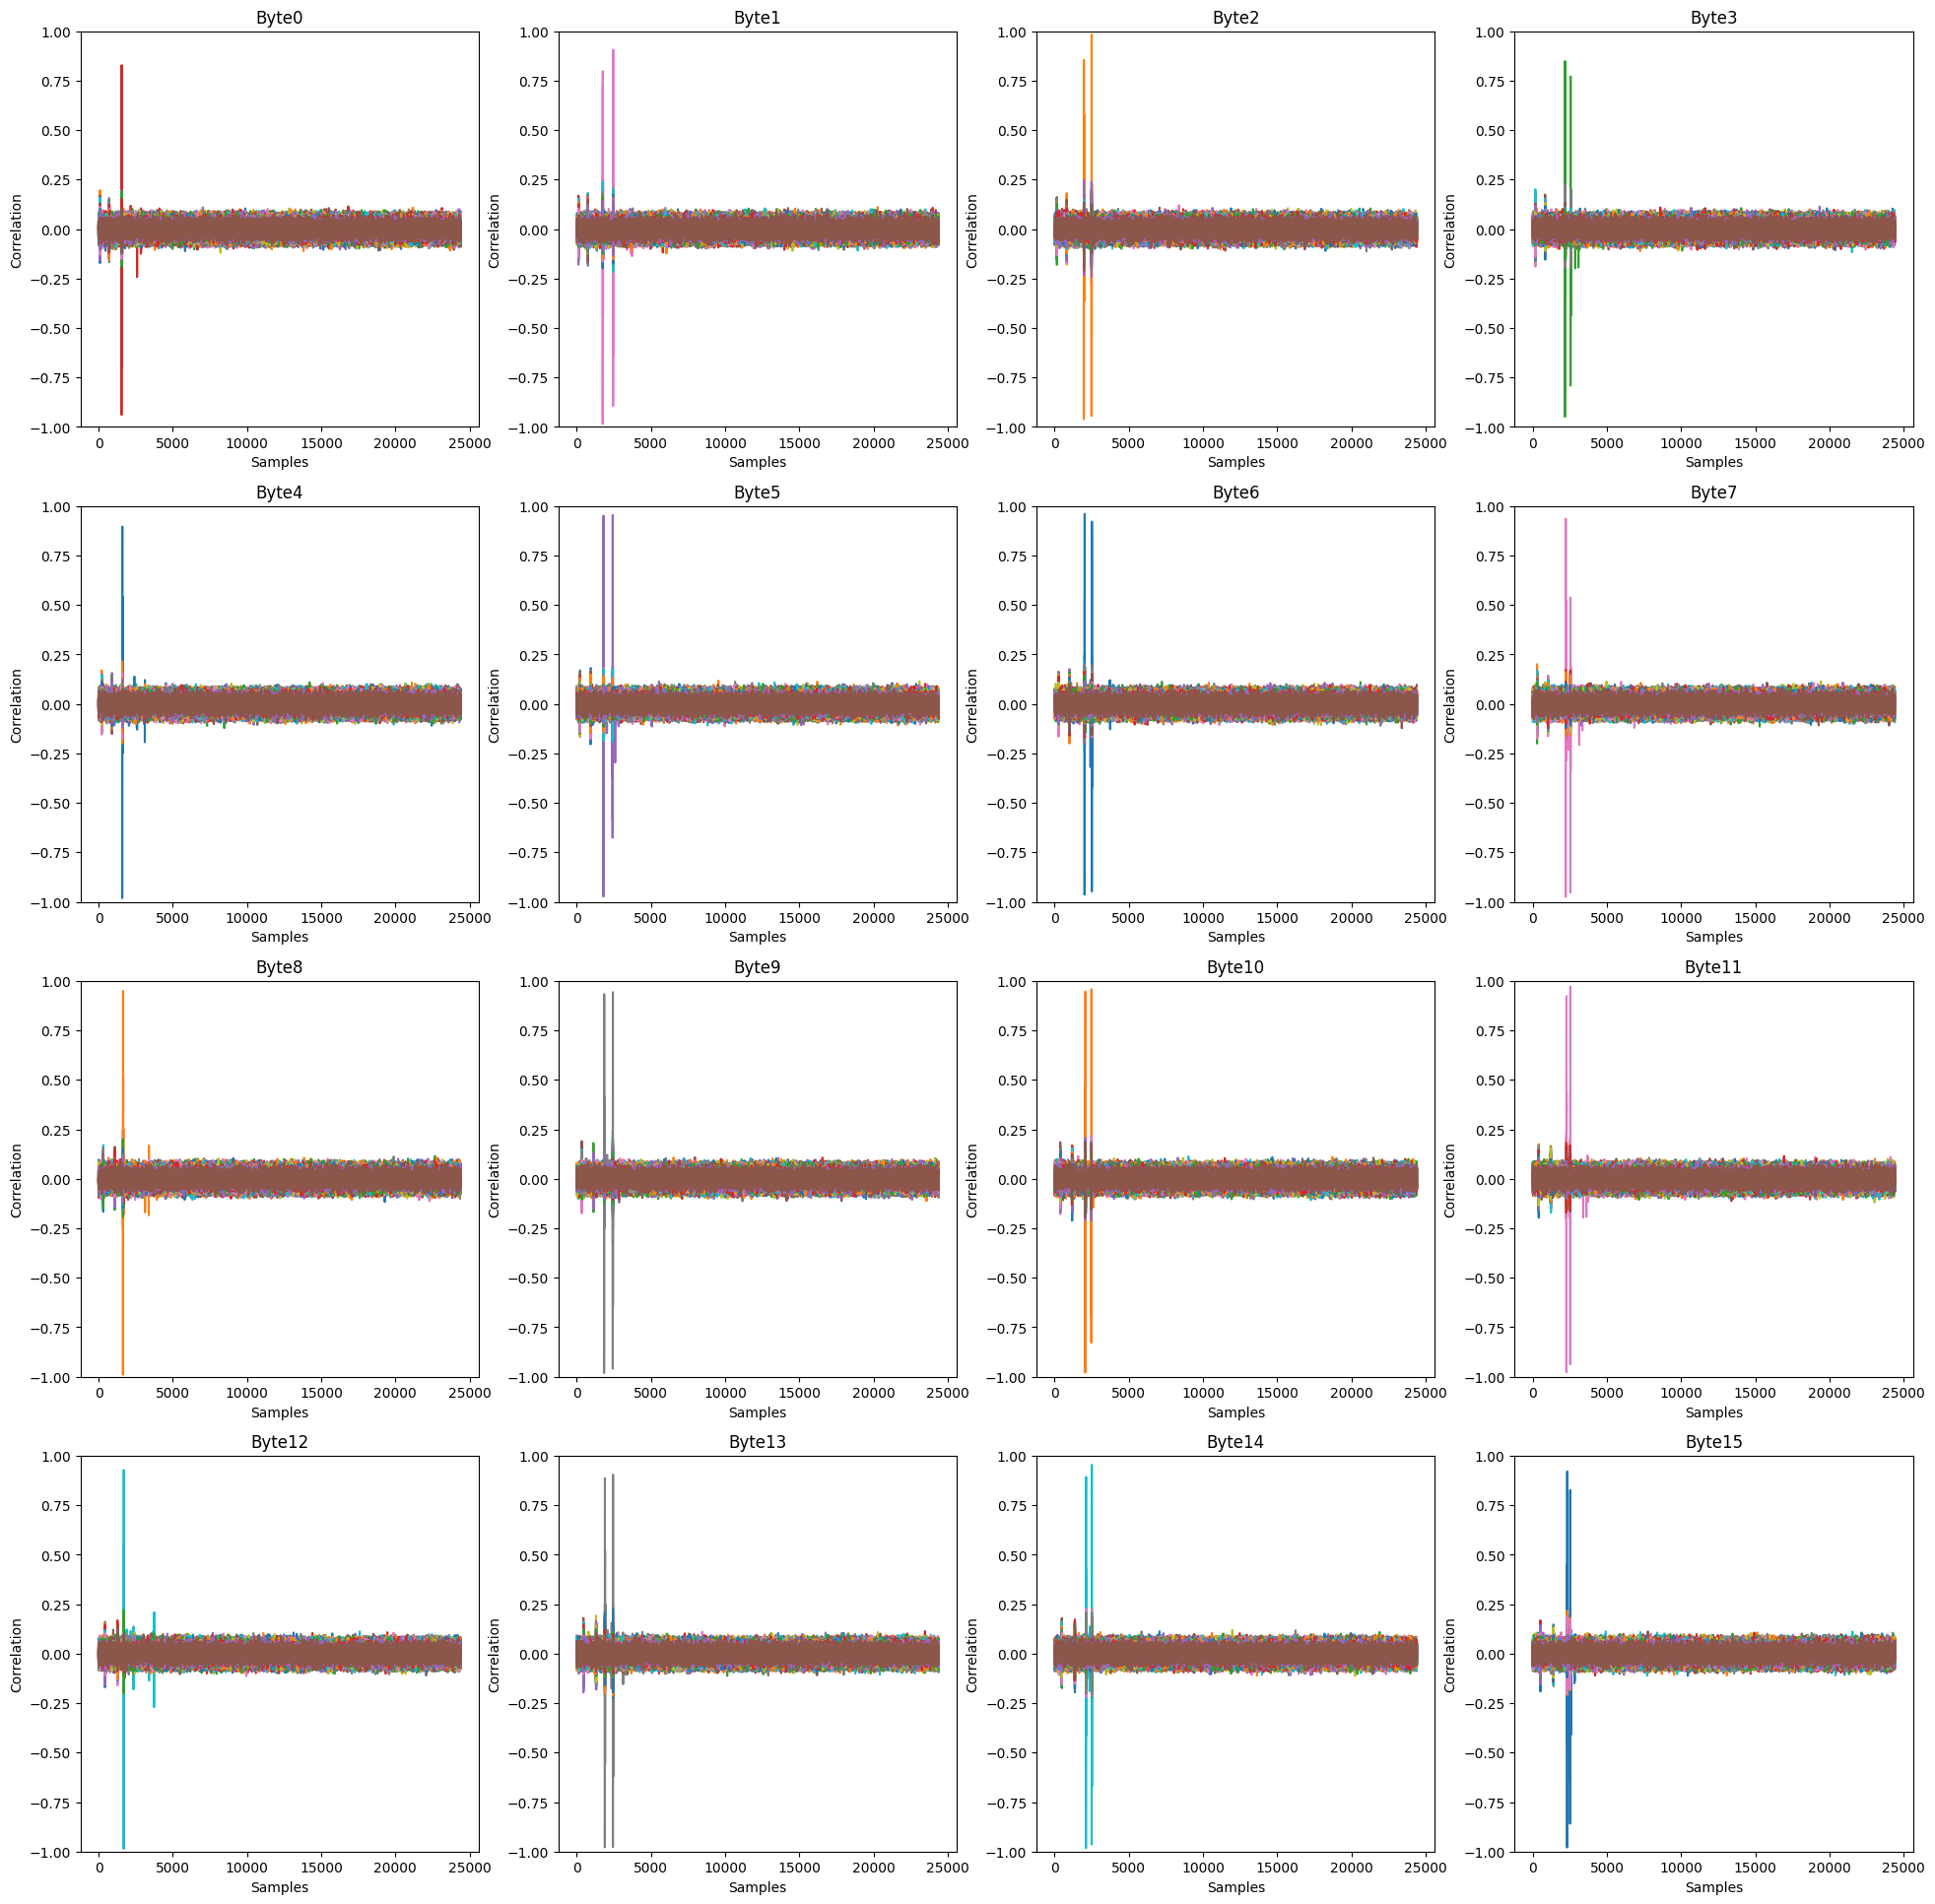

In [6]:
fig, axes = plt.subplots(4, 4, figsize=(24, 24))                   # 設定排版

for b in range(16):
    axes[b // 4, b % 4].set_title("Byte{}".format(b))
    axes[b // 4, b % 4].set_ylim(-1, 1)
    axes[b // 4, b % 4].set_xlabel('Samples')
    axes[b // 4, b % 4].set_ylabel('Correlation')
    axes[b // 4, b % 4].plot(r[b, :, :].T)

## 印出所有Byte中有最大相關係數的附近幾列

Guess Key:[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]


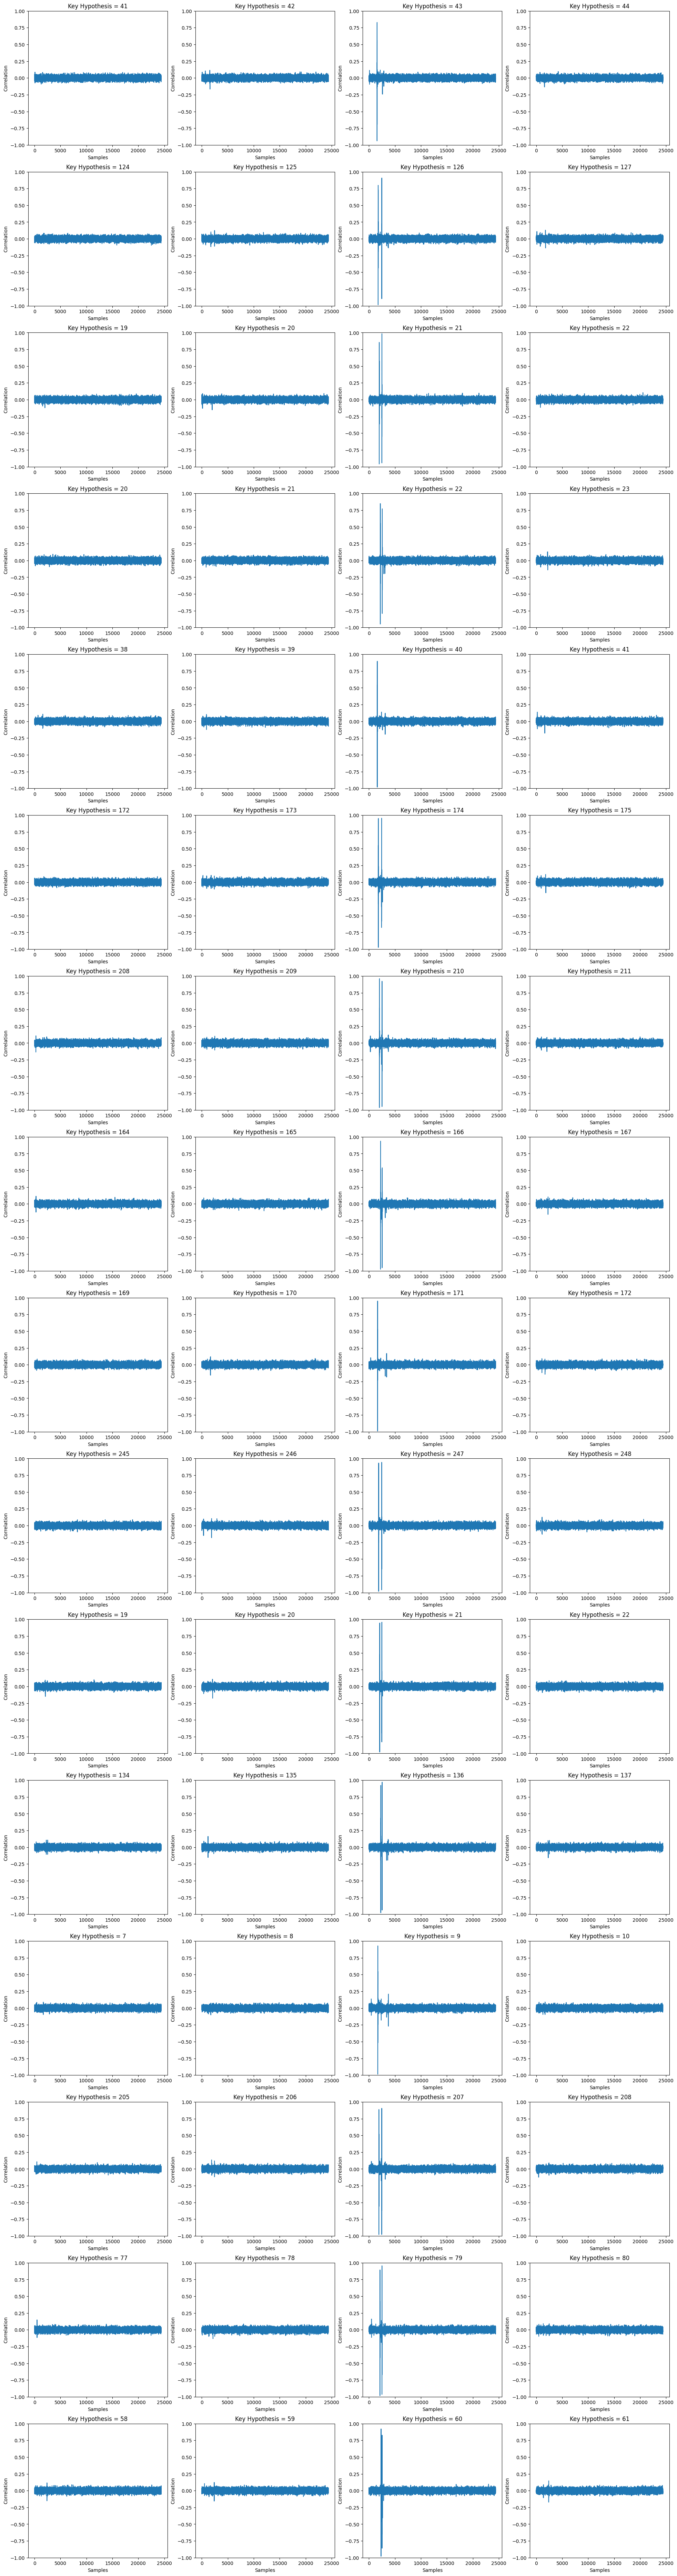

In [7]:
fig, axes = plt.subplots(16, 4, figsize=(24, 96))                   # 設定排版

print("Guess Key:", end="")
print(Guess_Key)

for b in range(16):
    for j in range(4):
        axes[b, j % 4].set_title("Key Hypothesis = {}".format(Guess_Key[b]+j%4-2))
        axes[b, j % 4].set_ylim(-1, 1)
        axes[b, j % 4].set_xlabel('Samples')
        axes[b, j % 4].set_ylabel('Correlation')
        axes[b, j % 4].plot(r[b, Guess_Key[b]+j%4-2:Guess_Key[b]+j%4-1, :].T)

## 圖2

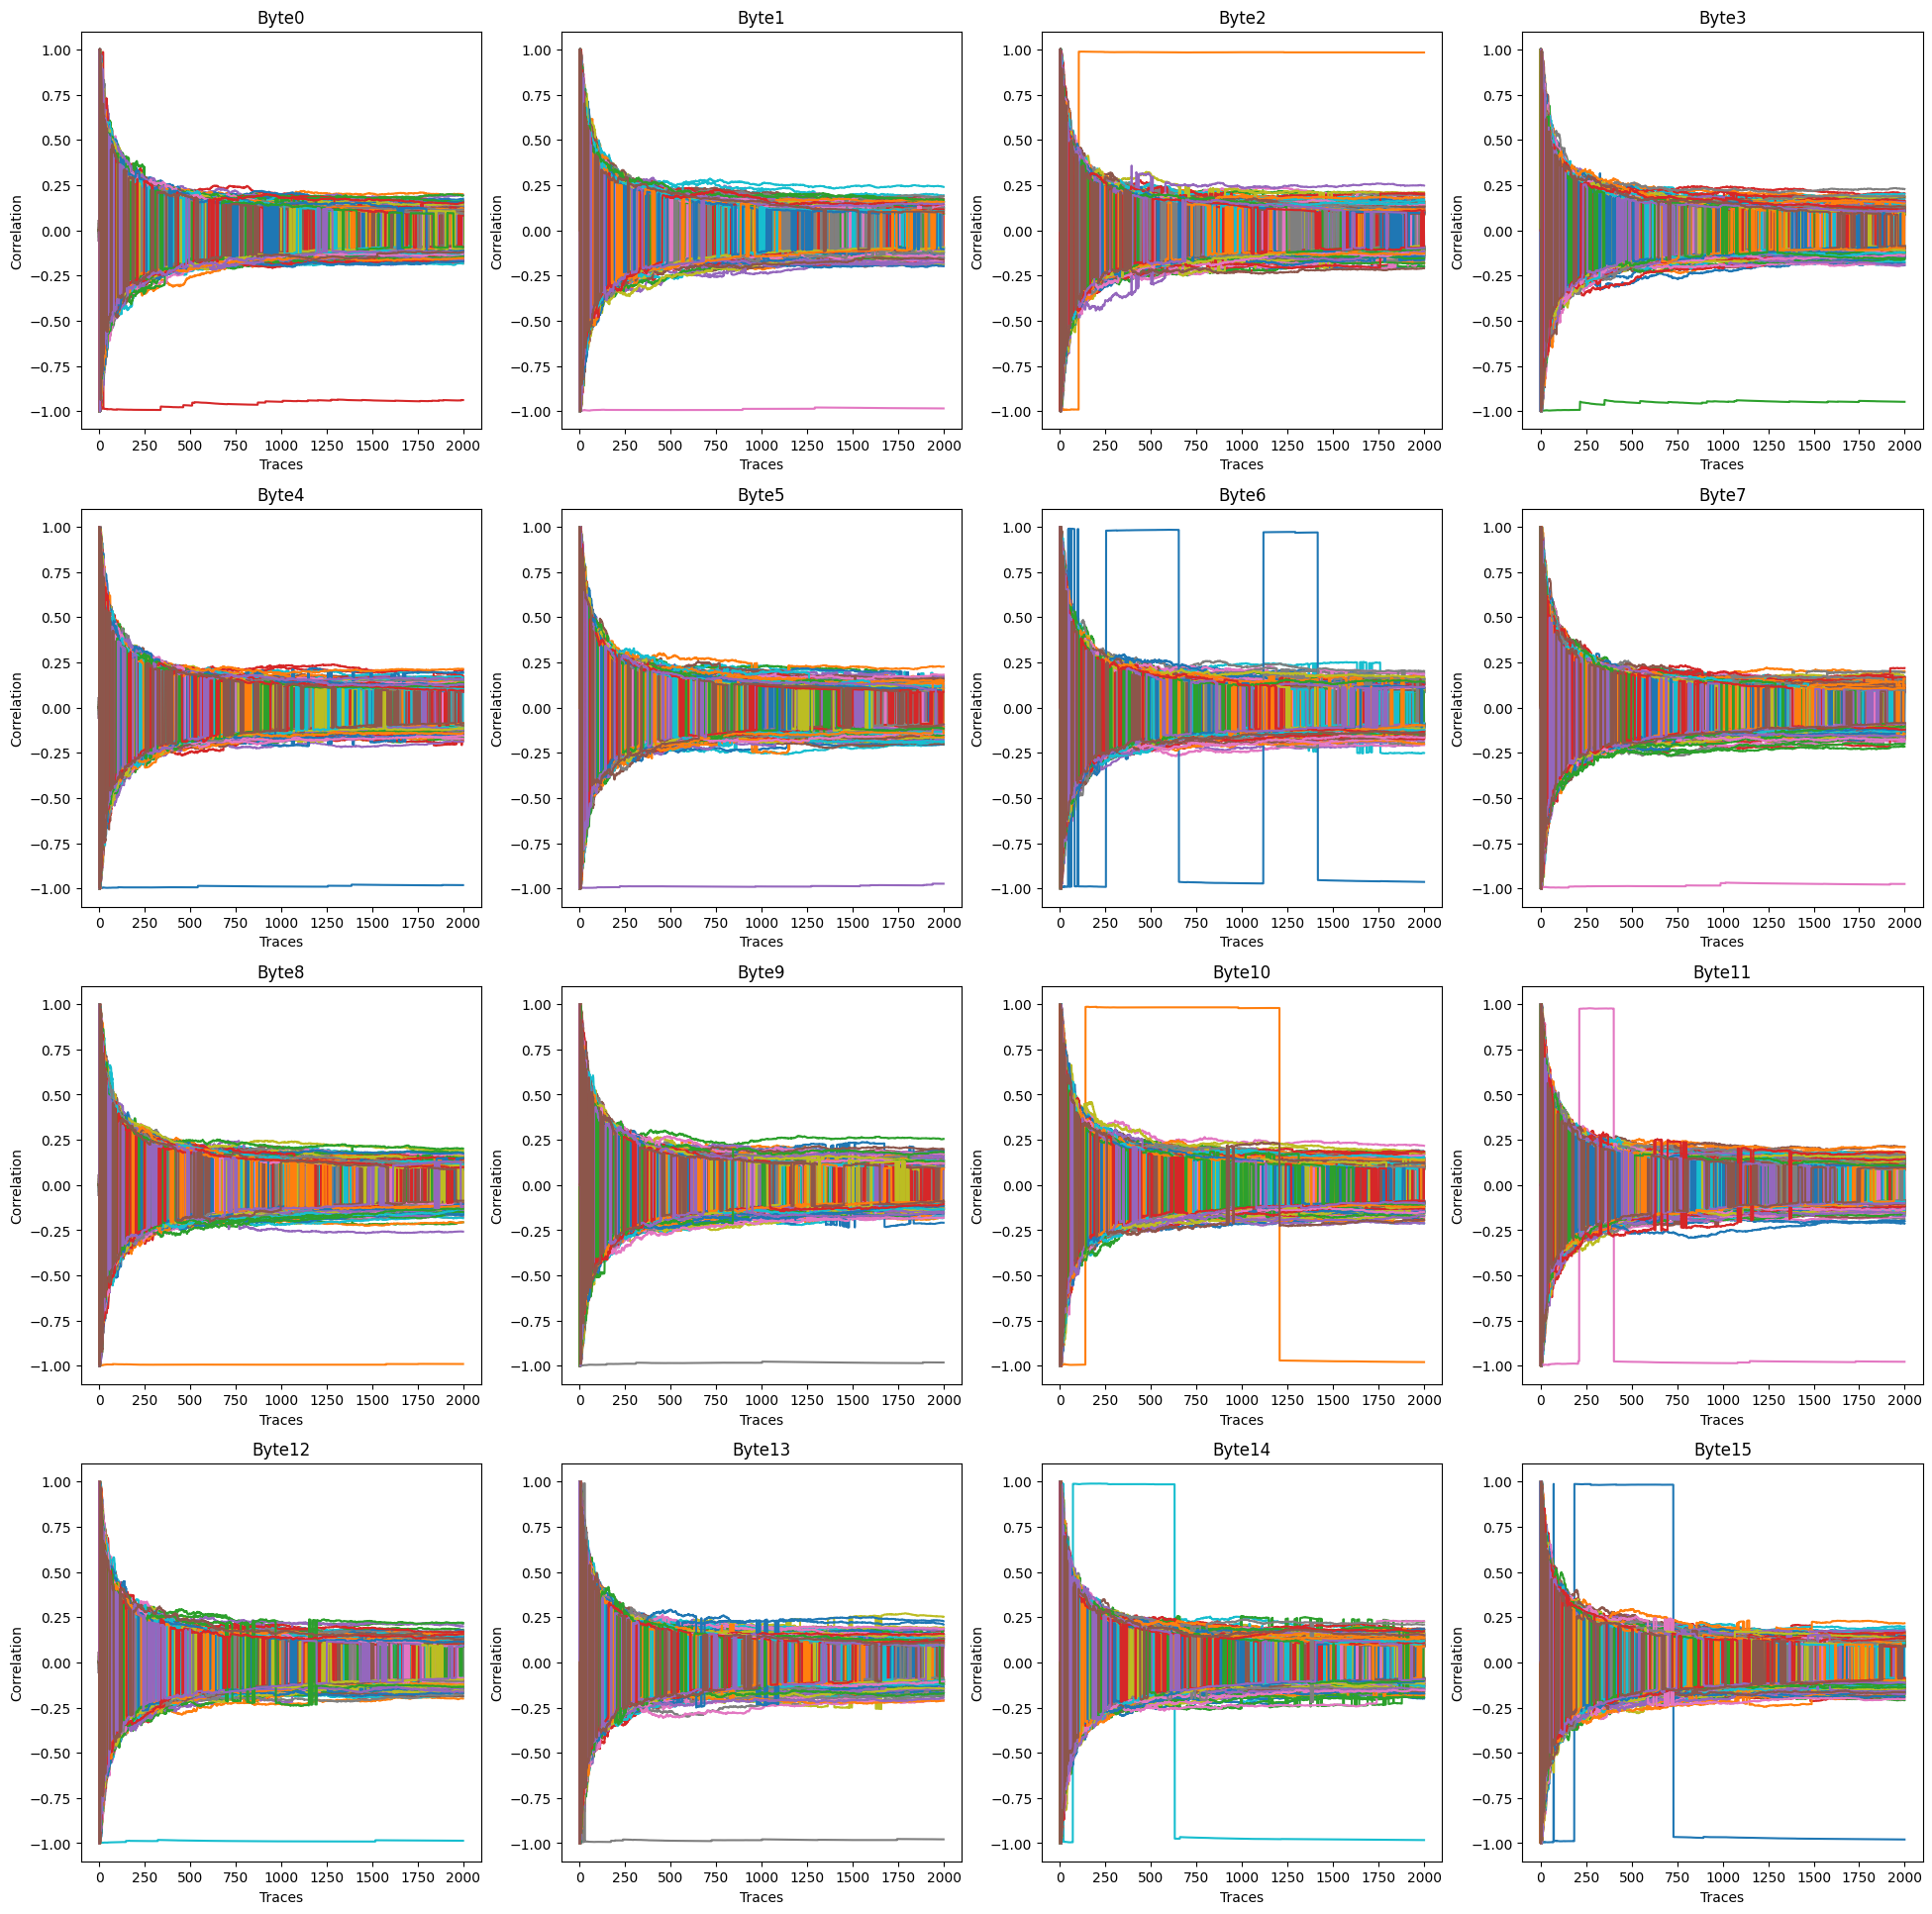

In [8]:
fig, axes = plt.subplots(4, 4, figsize=(24, 24))                   # 設定排版

for b in range(16):
    axes[b // 4, b % 4].set_title("Byte{}".format(b))
    axes[b // 4, b % 4].set_xlabel('Traces')
    axes[b // 4, b % 4].set_ylabel('Correlation')
    axes[b // 4, b % 4].plot(max_coef_per_row[:, b, :])